In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/Dataset1.zip" -d "/content/drive/MyDrive/"


Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Dataset1/Train/Fake/fake_2290.jpg  
  inflating: /content/drive/MyDrive/Dataset1/Train/Fake/fake_2291.jpg  
  inflating: /content/drive/MyDrive/Dataset1/Train/Fake/fake_2292.jpg  
  inflating: /content/drive/MyDrive/Dataset1/Train/Fake/fake_2293.jpg  
  inflating: /content/drive/MyDrive/Dataset1/Train/Fake/fake_2294.jpg  
  inflating: /content/drive/MyDrive/Dataset1/Train/Fake/fake_2295.jpg  
  inflating: /content/drive/MyDrive/Dataset1/Train/Fake/fake_2296.jpg  
  inflating: /content/drive/MyDrive/Dataset1/Train/Fake/fake_2297.jpg  
  inflating: /content/drive/MyDrive/Dataset1/Train/Fake/fake_2298.jpg  
  inflating: /content/drive/MyDrive/Dataset1/Train/Fake/fake_2299.jpg  
  inflating: /content/drive/MyDrive/Dataset1/Train/Fake/fake_23.jpg  
  inflating: /content/drive/MyDrive/Dataset1/Train/Fake/fake_230.jpg  
  inflating: /content/drive/MyDrive/Dataset1/Train/Fake/fake_2300.jpg  
  inflating: /co

In [3]:
!ls "/content/drive/MyDrive/"


'archive (1) (1).zip'
 archive.zip
 best_deepfake_model.h5
'Colab Notebooks'
 Dataset1
 Dataset1.zip
'dataset (1).zip'
 dataset_cleaned
 dataset_extracted
 dataset_face_cropped
 dataset_segmented
 dataset_segmented_embeddings
 dataset_split
 dataset_split_balanced
 dataset.zip
'Document from Haritha✨✨'
'Document from Haritha✨✨ (1).pdf'
'Document from Haritha✨✨ (2).pdf'
'Document from Haritha✨✨.pdf'
 efficientnet_best.h5
 efficientnet_best_ls.h5
 efficientnet_cbcr_fft_best_short.h5
 efficientnet_rgb_best.h5
 extracted_folder
'INCIDENT ZERO-HUNT THE HACKER FEEDBACK FORM.gform'
 Incident_Zero___Hunt_the_Hacker_participants.gsheet
 kfold_models
 kfold_models_dataset1
 kfold_models_xception
 microplastic_ppt.gdoc
 microplastic_ppt.pdf
'Untitled document (1).gdoc'
'Untitled document (2).gdoc'
'Untitled document (3).gdoc'
'Untitled document.gdoc'
'Untitled document.pdf'
'Untitled form.gform'
 xception_best.h5
 xception_seg_best.h5


In [4]:
!ls "/content/drive/MyDrive/Dataset1"


Test  Train  Validation


In [5]:
import os

base_dir = "/content/drive/MyDrive/Dataset1"
splits = ['Train', 'Validation', 'Test']
classes = ['Real', 'Fake']

print("📂 Dataset Summary:\n")

valid_ext = ('.png', '.jpg', '.jpeg', '.jfif', '.webp', '.bmp')

for split in splits:
    print(f"--- {split} ---")
    split_path = os.path.join(base_dir, split)

    for cls in classes:
        class_path = os.path.join(split_path, cls)

        if os.path.exists(class_path):
            num_images = sum([
                len([f for f in files if f.lower().endswith(valid_ext)])
                for _, _, files in os.walk(class_path)
            ])
            print(f"{cls:>6}: {num_images} images")
        else:
            print(f"{cls:>6}: Folder not found ❌")
    print()


📂 Dataset Summary:

--- Train ---
  Real: 2508 images
  Fake: 2508 images

--- Validation ---
  Real: 708 images
  Fake: 708 images

--- Test ---
  Real: 252 images
  Fake: 252 images



In [6]:
import os, shutil, random, math, cv2, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc


In [8]:
import os
import cv2
import glob
import numpy as np
from tqdm import tqdm

DATA_ROOT = "/content/drive/MyDrive/Dataset1"
                # your dataset
SEG_DIR = "/content/Dataset1_segmented"         # output segmented dataset

SPLITS = ["Train", "Validation", "Test"]
CLASSES = ["Real", "Fake"]

IMG_SIZE = (128, 128)

# -------------------------
# Face crop + segmentation
# -------------------------
def crop_face_and_segment(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(
        cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    )
    faces = face_cascade.detectMultiScale(gray, 1.1, 4, minSize=(30, 30))

    if len(faces) == 0:
        return cv2.resize(img, IMG_SIZE)

    x, y, w, h = faces[0]
    face = img[y:y+h, x:x+w]

    hsv = cv2.cvtColor(face, cv2.COLOR_BGR2HSV)
    lower = np.array([0, 30, 60])
    upper = np.array([20, 150, 255])
    mask = cv2.inRange(hsv, lower, upper)
    mask = cv2.GaussianBlur(mask, (5,5), 0)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))

    if mask.sum() < 10:
        output = cv2.resize(face, IMG_SIZE)
    else:
        segmented = cv2.bitwise_and(face, face, mask=mask)
        output = cv2.resize(segmented, IMG_SIZE)

    return output


# -------------------------
# Create segmented folders
# -------------------------
for split in SPLITS:
    for cls in CLASSES:
        os.makedirs(os.path.join(SEG_DIR, split, cls), exist_ok=True)


print("\n========== STARTING SEGMENTATION ==========\n")

# -------------------------
# Segment split/classwise
# -------------------------
for split in SPLITS:
    print(f"\n🔄 Processing: {split}")

    for cls in CLASSES:
        print(f" → Class: {cls}")

        src_dir = os.path.join(DATA_ROOT, split, cls)
        dst_dir = os.path.join(SEG_DIR, split, cls)

        images = glob.glob(os.path.join(src_dir, "*"))

        for img_path in tqdm(images, desc=f"{split}-{cls}", unit="img"):
            try:
                out = crop_face_and_segment(img_path)
                if out is None:
                    continue

                out_rgb = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)

                filename = os.path.basename(img_path)
                save_path = os.path.join(dst_dir, filename)

                # avoid filename clash
                if os.path.exists(save_path):
                    base, ext = os.path.splitext(filename)
                    save_path = os.path.join(dst_dir, base + "_dup" + ext)

                cv2.imwrite(save_path, cv2.cvtColor(out_rgb, cv2.COLOR_RGB2BGR))

            except Exception as e:
                print("Error:", img_path, e)


print("\n✅ Segmentation Completed!")
print("Segmented dataset saved at:", SEG_DIR)


# -------- Quick Count --------
print("\n📌 Segmented Image Counts:")
for split in SPLITS:
    for cls in CLASSES:
        count = len(glob.glob(os.path.join(SEG_DIR, split, cls, "*")))
        print(f"{split}/{cls}: {count} images")



========== STARTING SEGMENTATION ==========


🔄 Processing: Train
 → Class: Real


Train-Real: 100%|██████████| 2508/2508 [03:45<00:00, 11.13img/s]


 → Class: Fake


Train-Fake: 100%|██████████| 2508/2508 [03:41<00:00, 11.33img/s]



🔄 Processing: Validation
 → Class: Real


Validation-Real: 100%|██████████| 708/708 [01:03<00:00, 11.15img/s]


 → Class: Fake


Validation-Fake: 100%|██████████| 708/708 [00:59<00:00, 11.97img/s]



🔄 Processing: Test
 → Class: Real


Test-Real: 100%|██████████| 252/252 [00:19<00:00, 12.91img/s]


 → Class: Fake


Test-Fake: 100%|██████████| 252/252 [00:19<00:00, 12.90img/s]


✅ Segmentation Completed!
Segmented dataset saved at: /content/Dataset1_segmented

📌 Segmented Image Counts:
Train/Real: 2508 images
Train/Fake: 2508 images
Validation/Real: 708 images
Validation/Fake: 708 images
Test/Real: 252 images
Test/Fake: 252 images


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import pandas as pd
import math
import tensorflow as tf # Import tensorflow for backend operations

def build_model(input_shape=(128,128,3)):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2,2),
        BatchNormalization(),

        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        BatchNormalization(),

        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        BatchNormalization(),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Quick sanity: build and show summary
tmp_mod = build_model()
tmp_mod.summary()
del tmp_mod

# -------------------------
# 7. K-Fold training
# -------------------------
n_splits = 5
epochs = 5           # change as needed
batch_size = 32
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42) # Using SEED=42 from earlier context

histories = []
models_paths = []   # file paths for saved best model per fold
models = []         # List to store trained models

# Data augmentation / normalization
datagen = ImageDataGenerator(rescale=1.0/255.0)

fold_no = 0
for train_idx, val_idx in kf.split(image_paths):
    fold_no += 1
    print(f"\n=== Fold {fold_no}/{n_splits} ===")
    train_paths = image_paths[train_idx]; train_labels = labels[train_idx]
    val_paths = image_paths[val_idx]; val_labels = labels[val_idx]

    train_df = pd.DataFrame({"filename": train_paths, "class": train_labels})
    val_df = pd.DataFrame({"filename": val_paths, "class": val_labels})

    train_gen = datagen.flow_from_dataframe(
        train_df, x_col="filename", y_col="class",
        target_size=(128,128), class_mode='raw', batch_size=batch_size, shuffle=True
    )
    val_gen = datagen.flow_from_dataframe(
        val_df, x_col="filename", y_col="class",
        target_size=(128,128), class_mode='raw', batch_size=batch_size, shuffle=False
    )

    model = build_model()

    fold_model_path = f"/content/drive/MyDrive/kfold_models/fold_{fold_no}_best.h5"
    os.makedirs(os.path.dirname(fold_model_path), exist_ok=True)
    cp = ModelCheckpoint(fold_model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    es = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=False, verbose=1)

    steps_per_epoch = math.ceil(train_gen.samples / train_gen.batch_size)
    validation_steps = math.ceil(val_gen.samples / val_gen.batch_size)

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        callbacks=[cp, es],
        verbose=1
    )

    histories.append(history)
    models_paths.append(fold_model_path)
    models.append(model) # Store the trained model
    # free memory
    tf.keras.backend.clear_session()

print("\nK-Fold training finished. Saved best models for each fold at:")
print("\n".join(models_paths))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,665 (12.61 MB)

 Trainable params: 3,305,217 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)


=== Fold 1/5 ===
Found 5145 validated image filenames.
Found 1287 validated image filenames.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5734 - loss: 0.9846
Epoch 1: val_accuracy improved from -inf to 0.48796, saving model to /content/drive/MyDrive/kfold_models/fold_1_best.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.5737 - loss: 0.9838 - val_accuracy: 0.4880 - val_loss: 0.8533
Epoch 2/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7566 - loss: 0.5209
Epoch 2: val_accuracy improved from 0.48796 to 0.62937, saving model to /content/drive/MyDrive/kfold_models/fold_1_best.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.7566 - loss: 0.5208 - val_accuracy: 0.6294 - val_loss: 0.7055
Epoch 3/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8273 - loss: 0.3741
Epoch 3: val_accuracy did not improve from 0.62937
161/161 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.8273 - loss: 0.3740 - val_accuracy: 0.6263 - val_loss: 0.8085
Epoch 4/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8864 - loss: 0.2670
Epoch 4: val_accuracy improved from 0.62937 to 0.77855, saving model to /content/drive/MyDrive/kfold_models/fold_1_best.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.8864 - loss: 0.2670 - val_accuracy: 0.7786 - val_loss: 0.5180
Epoch 5/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9134 - loss: 0.2061
Epoch 5: val_accuracy did not improve from 0.77855
161/161 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.9134 - loss: 0.2061 - val_accuracy: 0.7576 - val_loss: 0.5737

=== Fold 2/5 ===
Found 5145 validated image filenames.
Found 1287 validated image filenames.
Epoch 1/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5759 - loss: 0.9948
Epoch 1: val_accuracy improved from -inf to 0.51049, saving model to /content/drive/MyDrive/kfold_models/fold_2_best.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.5762 - loss: 0.9940 - val_accuracy: 0.5105 - val_loss: 0.7689
Epoch 2/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7501 - loss: 0.5315
Epoch 2: val_accuracy improved from 0.51049 to 0.62393, saving model to /content/drive/MyDrive/kfold_models/fold_2_best.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.7502 - loss: 0.5314 - val_accuracy: 0.6239 - val_loss: 0.7594
Epoch 3/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8528 - loss: 0.3386
Epoch 3: val_accuracy improved from 0.62393 to 0.68065, saving model to /content/drive/MyDrive/kfold_models/fold_2_best.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.8528 - loss: 0.3387 - val_accuracy: 0.6807 - val_loss: 0.6880
Epoch 4/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9008 - loss: 0.2504
Epoch 4: val_accuracy improved from 0.68065 to 0.78399, saving model to /content/drive/MyDrive/kfold_models/fold_2_best.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.9008 - loss: 0.2504 - val_accuracy: 0.7840 - val_loss: 0.4708
Epoch 5/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9323 - loss: 0.1781
Epoch 5: val_accuracy improved from 0.78399 to 0.81197, saving model to /content/drive/MyDrive/kfold_models/fold_2_best.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.9322 - loss: 0.1781 - val_accuracy: 0.8120 - val_loss: 0.4340

=== Fold 3/5 ===
Found 5146 validated image filenames.
Found 1286 validated image filenames.
Epoch 1/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5812 - loss: 0.9631
Epoch 1: val_accuracy improved from -inf to 0.57776, saving model to /content/drive/MyDrive/kfold_models/fold_3_best.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.5814 - loss: 0.9624 - val_accuracy: 0.5778 - val_loss: 0.6805
Epoch 2/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7775 - loss: 0.5010
Epoch 2: val_accuracy did not improve from 0.57776
161/161 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.7775 - loss: 0.5010 - val_accuracy: 0.5770 - val_loss: 0.7396
Epoch 3/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8408 - loss: 0.3638
Epoch 3: val_accuracy improved from 0.57776 to 0.66563, saving model to /content/drive/MyDrive/kfold_models/fold_3_best.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.8408 - loss: 0.3638 - val_accuracy: 0.6656 - val_loss: 0.7759
Epoch 4/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8892 - loss: 0.2688
Epoch 4: val_accuracy improved from 0.66563 to 0.75739, saving model to /content/drive/MyDrive/kfold_models/fold_3_best.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.8892 - loss: 0.2688 - val_accuracy: 0.7574 - val_loss: 0.5331
Epoch 5/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9187 - loss: 0.1966
Epoch 5: val_accuracy improved from 0.75739 to 0.79471, saving model to /content/drive/MyDrive/kfold_models/fold_3_best.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.9187 - loss: 0.1966 - val_accuracy: 0.7947 - val_loss: 0.5064

=== Fold 4/5 ===
Found 5146 validated image filenames.
Found 1286 validated image filenames.
Epoch 1/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5750 - loss: 0.9874
Epoch 1: val_accuracy improved from -inf to 0.49533, saving model to /content/drive/MyDrive/kfold_models/fold_4_best.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.5753 - loss: 0.9867 - val_accuracy: 0.4953 - val_loss: 0.8470
Epoch 2/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7608 - loss: 0.5146
Epoch 2: val_accuracy improved from 0.49533 to 0.63686, saving model to /content/drive/MyDrive/kfold_models/fold_4_best.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.7608 - loss: 0.5146 - val_accuracy: 0.6369 - val_loss: 0.6578
Epoch 3/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8319 - loss: 0.3784
Epoch 3: val_accuracy did not improve from 0.63686
161/161 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.8319 - loss: 0.3783 - val_accuracy: 0.6330 - val_loss: 0.7030
Epoch 4/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8837 - loss: 0.2659
Epoch 4: val_accuracy improved from 0.63686 to 0.76439, saving model to /content/drive/MyDrive/kfold_models/fold_4_best.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.8837 - loss: 0.2659 - val_accuracy: 0.7644 - val_loss: 0.5005
Epoch 5/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9265 - loss: 0.2022
Epoch 5: val_accuracy improved from 0.76439 to 0.78694, saving model to /content/drive/MyDrive/kfold_models/fold_4_best.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.9265 - loss: 0.2022 - val_accuracy: 0.7869 - val_loss: 0.4909

=== Fold 5/5 ===
Found 5146 validated image filenames.
Found 1286 validated image filenames.
Epoch 1/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6097 - loss: 0.9813
Epoch 1: val_accuracy improved from -inf to 0.53421, saving model to /content/drive/MyDrive/kfold_models/fold_5_best.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.6099 - loss: 0.9806 - val_accuracy: 0.5342 - val_loss: 0.6753
Epoch 2/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7676 - loss: 0.5195
Epoch 2: val_accuracy improved from 0.53421 to 0.54743, saving model to /content/drive/MyDrive/kfold_models/fold_5_best.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.7676 - loss: 0.5195 - val_accuracy: 0.5474 - val_loss: 0.9131
Epoch 3/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8519 - loss: 0.3432
Epoch 3: val_accuracy improved from 0.54743 to 0.75894, saving model to /content/drive/MyDrive/kfold_models/fold_5_best.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.8519 - loss: 0.3433 - val_accuracy: 0.7589 - val_loss: 0.5116
Epoch 4/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8941 - loss: 0.2698
Epoch 4: val_accuracy improved from 0.75894 to 0.77138, saving model to /content/drive/MyDrive/kfold_models/fold_5_best.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.8941 - loss: 0.2698 - val_accuracy: 0.7714 - val_loss: 0.5013
Epoch 5/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9228 - loss: 0.1939
Epoch 5: val_accuracy improved from 0.77138 to 0.78927, saving model to /content/drive/MyDrive/kfold_models/fold_5_best.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.9228 - loss: 0.1939 - val_accuracy: 0.7893 - val_loss: 0.5202

K-Fold training finished. Saved best models for each fold at:
/content/drive/MyDrive/kfold_models/fold_1_best.h5
/content/drive/MyDrive/kfold_models/fold_2_best.h5
/content/drive/MyDrive/kfold_models/fold_3_best.h5
/content/drive/MyDrive/kfold_models/fold_4_best.h5
/content/drive/MyDrive/kfold_models/fold_5_best.h5


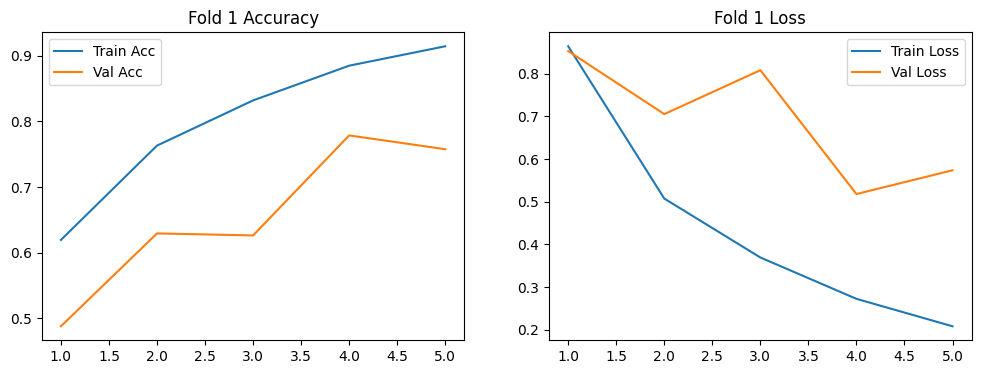

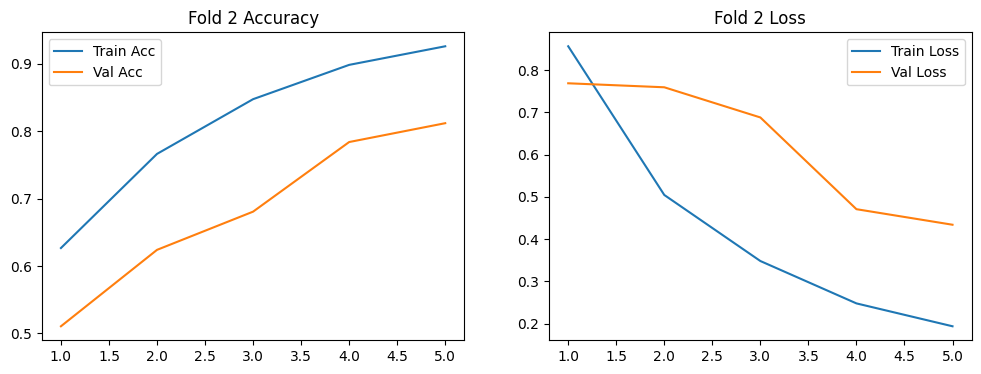

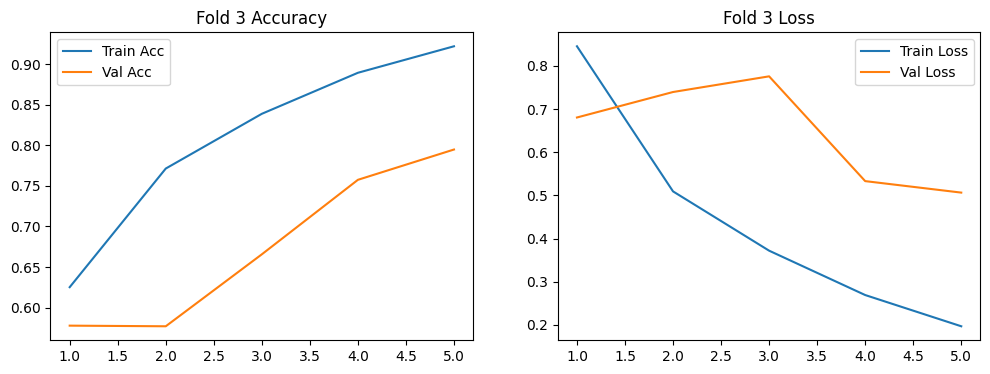

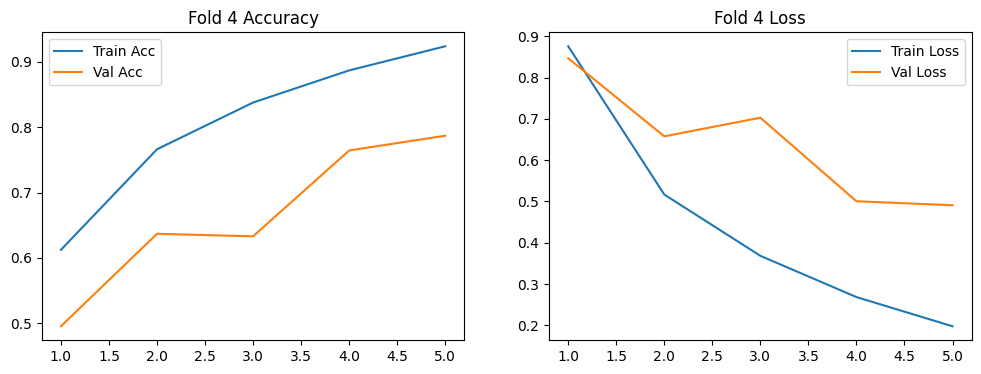

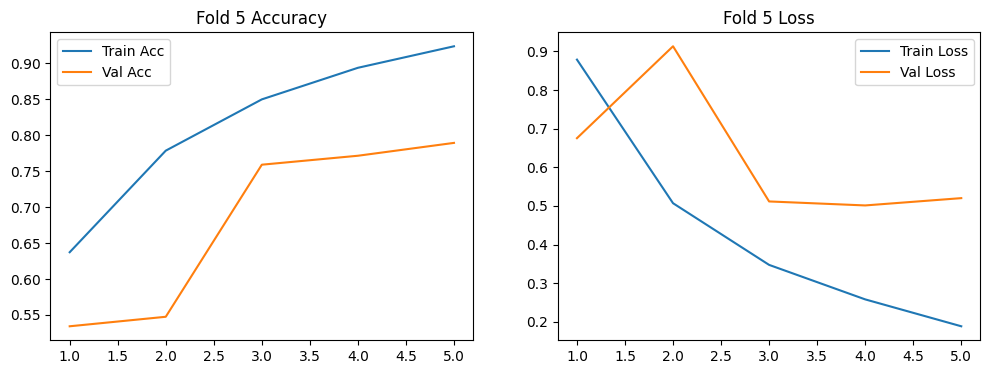

In [28]:
import matplotlib.pyplot as plt

for i, h in enumerate(histories):
    acc = h.history.get('accuracy', [])
    val_acc = h.history.get('val_accuracy', [])
    loss = h.history.get('loss', [])
    val_loss = h.history.get('val_loss', [])
    epochs_range = range(1, len(acc)+1)

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label='Train Acc')
    plt.plot(epochs_range, val_acc, label='Val Acc')
    plt.title(f'Fold {i+1} Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.title(f'Fold {i+1} Loss')
    plt.legend()
    plt.show()

In [29]:
best_val_acc = -1.0
best_model_path = None

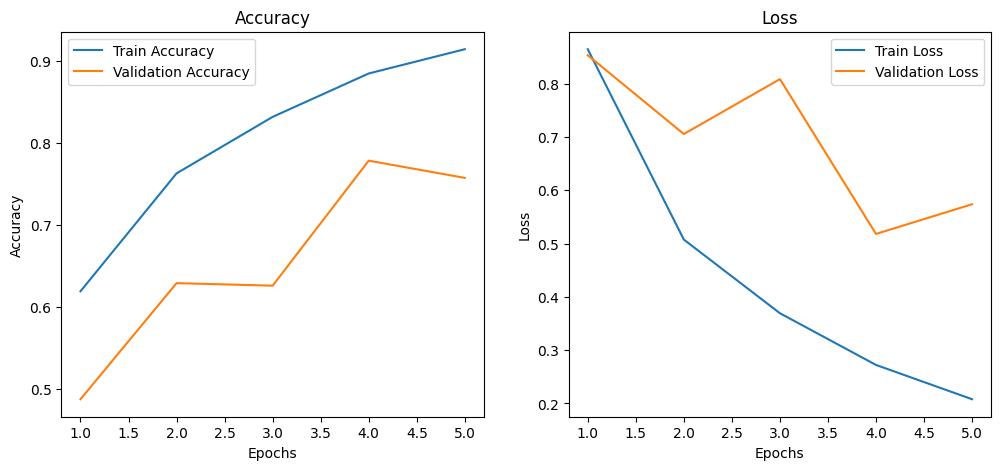

In [30]:
import matplotlib.pyplot as plt

history = histories[0]  # if you stored your history, otherwise skip

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label="Train Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label="Train Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()



==================== EVALUATION METRICS ====================


----- Fold 1 Evaluation -----


Found 1287 validated image filenames.
41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 298ms/step
Accuracy:  0.7786
Precision: 0.7095
Recall:    0.9163
F1-score:  0.7997
AUC:       0.8749


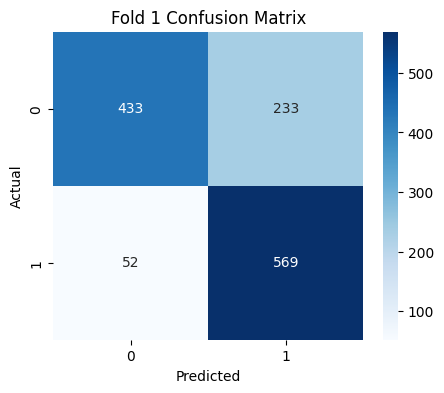

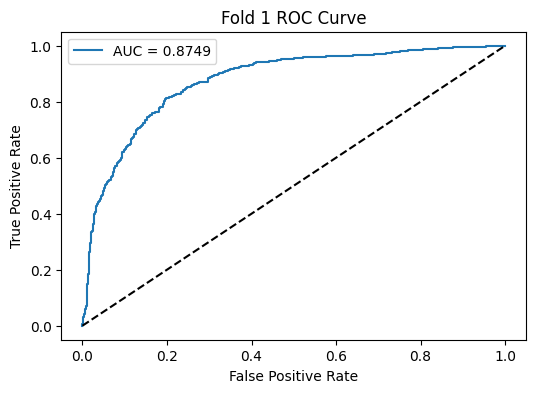


----- Fold 2 Evaluation -----


Found 1287 validated image filenames.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 275ms/step
Accuracy:  0.8120
Precision: 0.7961
Recall:    0.8336
F1-score:  0.8144
AUC:       0.8947


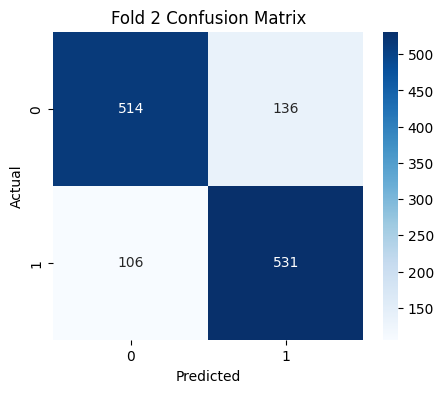

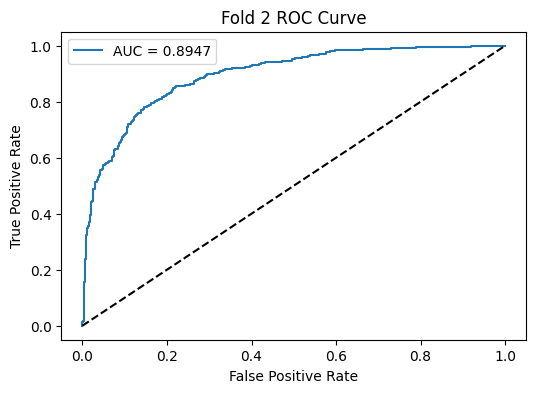


----- Fold 3 Evaluation -----


Found 1286 validated image filenames.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 272ms/step
Accuracy:  0.7947
Precision: 0.8198
Recall:    0.7675
F1-score:  0.7928
AUC:       0.8746


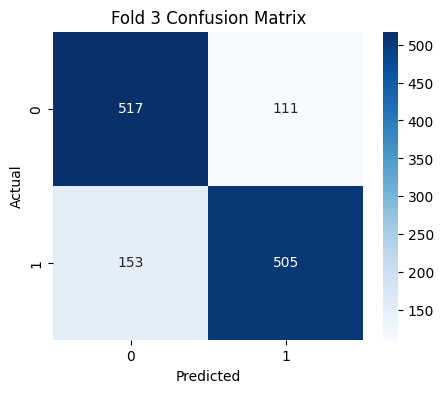

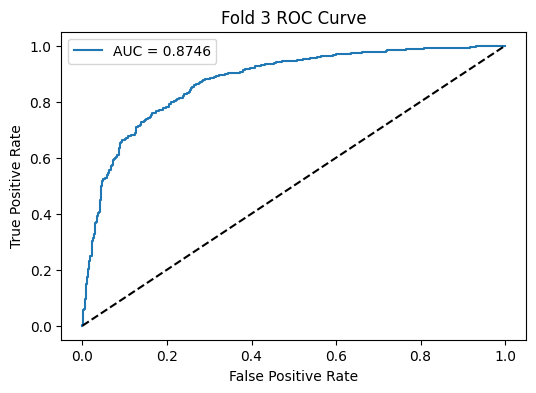


----- Fold 4 Evaluation -----


Found 1286 validated image filenames.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 300ms/step
Accuracy:  0.7869
Precision: 0.7524
Recall:    0.8493
F1-score:  0.7979
AUC:       0.8762


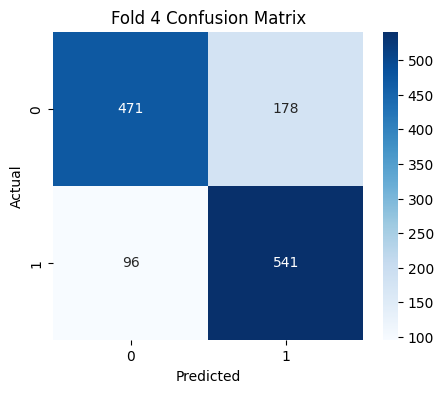

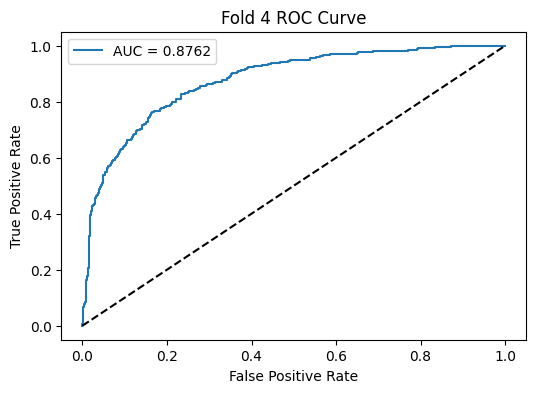


----- Fold 5 Evaluation -----


Found 1286 validated image filenames.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 293ms/step
Accuracy:  0.7893
Precision: 0.8172
Recall:    0.7617
F1-score:  0.7884
AUC:       0.8741


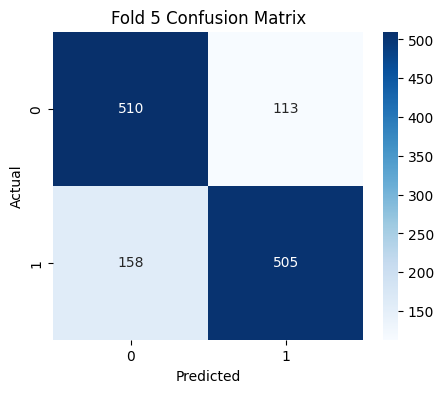

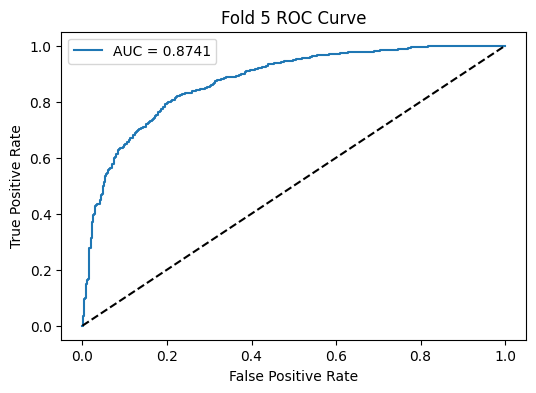


Best model: /content/drive/MyDrive/kfold_models/fold_2_best.h5
Best Validation Accuracy: 0.811965811965812


In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sns

print("\n==================== EVALUATION METRICS ====================\n")

fold_metrics = []

fold_no = 0
best_val_acc = -1
best_model_path = None

for train_idx, val_idx in kf.split(image_paths):
    fold_no += 1
    print(f"\n----- Fold {fold_no} Evaluation -----")

    model_path = models_paths[fold_no-1]
    model = tf.keras.models.load_model(model_path)

    val_paths = image_paths[val_idx]
    val_labels = labels[val_idx]

    val_df = pd.DataFrame({"filename": val_paths, "class": val_labels})
    val_gen = datagen.flow_from_dataframe(
        val_df, x_col="filename", y_col="class",
        target_size=(128,128), class_mode='raw',
        batch_size=batch_size, shuffle=False
    )

    # Predictions
    preds = model.predict(val_gen)
    preds_bin = (preds >= 0.5).astype(int).reshape(-1)

    y_true = val_labels
    y_pred = preds_bin

    # Metrics
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec  = recall_score(y_true, y_pred)
    f1   = f1_score(y_true, y_pred)

    # ROC-AUC
    fpr, tpr, _ = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"AUC:       {roc_auc:.4f}")

    fold_metrics.append([acc, prec, rec, f1, roc_auc])

    # Confusion Matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"Fold {fold_no} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve Plot
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0,1], [0,1], 'k--')
    plt.title(f"Fold {fold_no} ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    # Track the best model
    if acc > best_val_acc:
        best_val_acc = acc
        best_model_path = model_path

print("\nBest model:", best_model_path)
print("Best Validation Accuracy:", best_val_acc)


In [32]:
import numpy as np

fold_metrics = np.array(fold_metrics)

avg_accuracy  = fold_metrics[:,0].mean()
avg_precision = fold_metrics[:,1].mean()
avg_recall    = fold_metrics[:,2].mean()
avg_f1        = fold_metrics[:,3].mean()
avg_auc       = fold_metrics[:,4].mean()

print("\n==================== OVERALL METRICS (Across All Folds) ====================\n")
print(f"Overall Accuracy:  {avg_accuracy:.4f}")
print(f"Overall Precision: {avg_precision:.4f}")
print(f"Overall Recall:    {avg_recall:.4f}")
print(f"Overall F1-score:  {avg_f1:.4f}")
print(f"Overall AUC:       {avg_auc:.4f}")



==================== OVERALL METRICS (Across All Folds) ====================

Overall Accuracy:  0.7923
Overall Precision: 0.7790
Overall Recall:    0.8257
Overall F1-score:  0.7987
Overall AUC:       0.8789


In [68]:
fold_no = 0
for train_idx, val_idx in kf.split(image_paths):
    fold_no += 1
    path = models_paths[fold_no-1]
    if not os.path.exists(path):
        print("Model file missing:", path); continue
    model = tf.keras.models.load_model(path)
    # build a small generator for this fold's validation set
    val_paths = image_paths[val_idx]; val_labels = labels[val_idx]
    val_df = pd.DataFrame({"filename": val_paths, "class": val_labels})
    val_gen = datagen.flow_from_dataframe(val_df, x_col="filename", y_col="class",
                                          target_size=(128,128), class_mode='raw', batch_size=batch_size, shuffle=False)
    loss, acc = model.evaluate(val_gen, verbose=0)
    print(f"Fold {fold_no} val_acc = {acc:.4f}")
    if acc > best_val_acc:
        best_val_acc = acc
        best_model_path = path
    tf.keras.backend.clear_session()

print("Best model chosen:", best_model_path, "with val_acc =", best_val_acc)

# Load best model
best_model = tf.keras.models.load_model(best_model_path)
best_model.build((None, 128, 128, 3)) # Explicitly build the model

# Add a dummy call to ensure inputs and outputs are traced
import numpy as np # Ensure numpy is imported
_ = best_model.predict(np.zeros((1, 128, 128, 3)))

print("Loaded best model. Layers:")
for i, layer in enumerate(best_model.layers):
    print(i, layer.name, getattr(layer, "output_shape", ""))

Found 1287 validated image filenames.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Fold 1 val_acc = 0.7786


Found 1287 validated image filenames.
Fold 2 val_acc = 0.8120


Found 1286 validated image filenames.
Fold 3 val_acc = 0.7947


Found 1286 validated image filenames.
Fold 4 val_acc = 0.7869


Found 1286 validated image filenames.
Fold 5 val_acc = 0.7893
Best model chosen: /content/drive/MyDrive/kfold_models/fold_2_best.h5 with val_acc = 0.811965823173523


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
Loaded best model. Layers:
0 conv2d 
1 max_pooling2d 
2 batch_normalization 
3 conv2d_1 
4 max_pooling2d_1 
5 batch_normalization_1 
6 conv2d_2 
7 max_pooling2d_2 
8 batch_normalization_2 
9 flatten 
10 dense 
11 dropout 
12 dense_1 


In [80]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# -----------------------------
# Face crop + segmentation
# -----------------------------
IMG_SIZE = (128, 128)

def crop_face_and_segment(img_path):
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {img_path}")

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(
        cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    )
    faces = face_cascade.detectMultiScale(gray, 1.1, 4, minSize=(30, 30))

    if len(faces) == 0:
        # fallback: resize original
        return cv2.resize(img, IMG_SIZE)

    x, y, w, h = faces[0]
    face = img[y:y+h, x:x+w]

    # Simple segmentation via HSV mask
    hsv = cv2.cvtColor(face, cv2.COLOR_BGR2HSV)
    lower = np.array([0, 30, 60])
    upper = np.array([20, 150, 255])
    mask = cv2.inRange(hsv, lower, upper)
    mask = cv2.GaussianBlur(mask, (5,5), 0)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))

    if mask.sum() < 10:
        output = cv2.resize(face, IMG_SIZE)
    else:
        segmented = cv2.bitwise_and(face, face, mask=mask)
        output = cv2.resize(segmented, IMG_SIZE)

    return output

# -----------------------------
# Find last conv layer
# -----------------------------
def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D) or 'conv' in layer.name.lower():
            return layer.name
    raise ValueError("No Conv2D layer found in the model.")

# -----------------------------
# Grad-CAM display
# -----------------------------
def display_gradcam_from_array(img_arr, model, last_conv_name):
    input_tensor = np.expand_dims(img_arr / 255.0, 0).astype(np.float32)

    # Feature extractor
    feature_extractor = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=model.get_layer(last_conv_name).output
    )

    # Classifier after last conv
    classifier_input = tf.keras.Input(shape=feature_extractor.output.shape[1:])
    x = classifier_input
    start_collecting = False
    for layer in model.layers:
        if layer.name == last_conv_name:
            start_collecting = True
            continue
        if start_collecting:
            x = layer(x)
    classifier_model = tf.keras.models.Model(inputs=classifier_input, outputs=x)

    with tf.GradientTape() as tape:
        conv_outputs = feature_extractor(input_tensor)
        tape.watch(conv_outputs)
        preds = classifier_model(conv_outputs)
        loss = preds[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    conv_outputs = conv_outputs[0].numpy()
    grads = grads[0].numpy()

    weights = np.mean(grads, axis=(0,1))
    cam = np.dot(conv_outputs, weights)
    cam = np.maximum(cam, 0)
    cam = cam / (cam.max() + 1e-8)
    cam = cv2.resize(cam, IMG_SIZE)
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    overlay = np.uint8(0.4 * heatmap + img_arr)

    # Prediction
    full_model_preds = model.predict(input_tensor)
    prob = full_model_preds[0][0]
    label = "real" if prob >= 0.5 else "fake"

    plt.figure(figsize=(6,6))
    plt.imshow(overlay)
    plt.title(f"{label} (score={prob:.4f})")
    plt.axis('off')
    plt.show()

    return prob, label

# -----------------------------
# Predict + Grad-CAM (with cropping)
# -----------------------------
def predict_and_gradcam(img_path, model, last_conv_name=None):
    if last_conv_name is None:
        last_conv_name = find_last_conv_layer(model)

    # Crop and segment image
    img_arr = crop_face_and_segment(img_path)
    img_arr_rgb = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)

    # Display Grad-CAM
    prob, label = display_gradcam_from_array(img_arr_rgb, model, last_conv_name)
    return prob, label


Saving IMG1.jpg to IMG1 (11).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


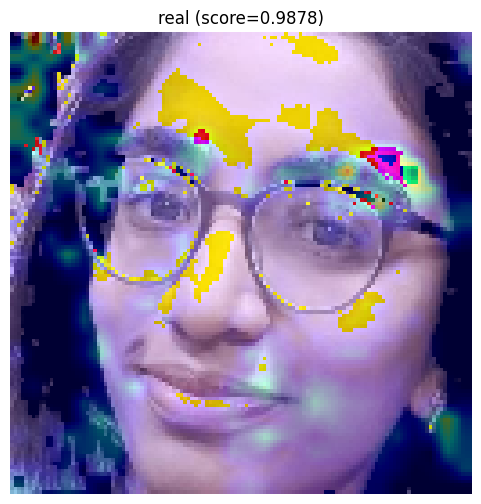

Prediction: real, Probability: 0.9878


In [81]:
from google.colab import files
import cv2
import numpy as np

# Upload image from browser
uploaded = files.upload()  # This will open a file picker

# Get the first uploaded file
for filename in uploaded.keys():
    img_path = filename
    break

# Now run your Grad-CAM function
last_conv = find_last_conv_layer(best_model)
prob, label = predict_and_gradcam(img_path, best_model, last_conv)

print(f"Prediction: {label}, Probability: {prob:.4f}")


Saving Screenshot 2025-11-15 204218.png to Screenshot 2025-11-15 204218 (2).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


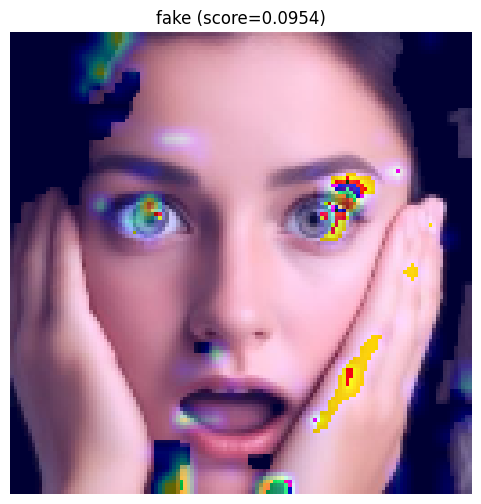

Prediction: fake, Probability: 0.0954


In [82]:
from google.colab import files
import cv2
import numpy as np

# Upload image from browser
uploaded = files.upload()  # This will open a file picker

# Get the first uploaded file
for filename in uploaded.keys():
    img_path = filename
    break

# Now run your Grad-CAM function
last_conv = find_last_conv_layer(best_model)
prob, label = predict_and_gradcam(img_path, best_model, last_conv)

print(f"Prediction: {label}, Probability: {prob:.4f}")


Saving Screenshot 2025-11-15 211558.png to Screenshot 2025-11-15 211558 (2).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


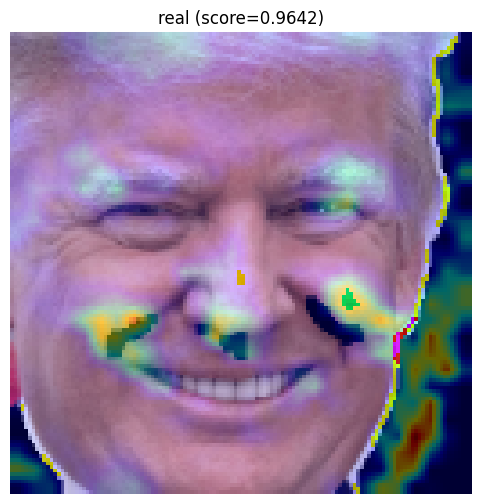

Prediction: real, Probability: 0.9642


In [83]:
from google.colab import files
import cv2
import numpy as np

# Upload image from browser
uploaded = files.upload()  # This will open a file picker

# Get the first uploaded file
for filename in uploaded.keys():
    img_path = filename
    break

# Now run your Grad-CAM function
last_conv = find_last_conv_layer(best_model)
prob, label = predict_and_gradcam(img_path, best_model, last_conv)

print(f"Prediction: {label}, Probability: {prob:.4f}")


Saving Screenshot 2025-11-15 205912.png to Screenshot 2025-11-15 205912.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


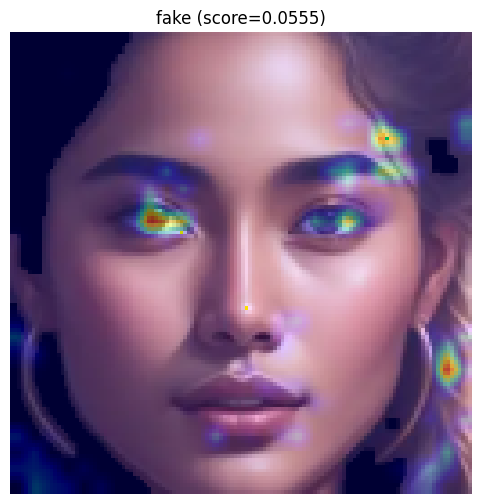

Prediction: fake, Probability: 0.0555


In [84]:
from google.colab import files
import cv2
import numpy as np

# Upload image from browser
uploaded = files.upload()  # This will open a file picker

# Get the first uploaded file
for filename in uploaded.keys():
    img_path = filename
    break

# Now run your Grad-CAM function
last_conv = find_last_conv_layer(best_model)
prob, label = predict_and_gradcam(img_path, best_model, last_conv)

print(f"Prediction: {label}, Probability: {prob:.4f}")


Saving Screenshot 2025-11-15 211926.png to Screenshot 2025-11-15 211926.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


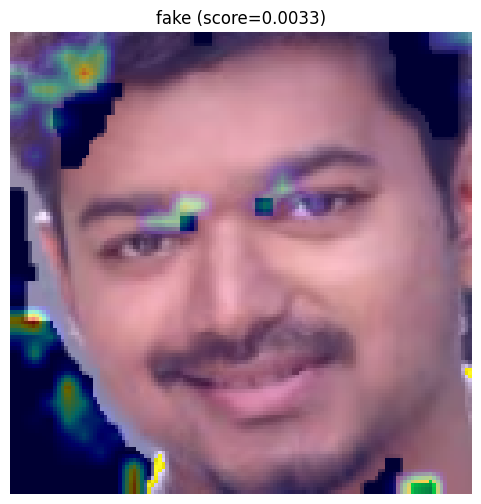

Prediction: fake, Probability: 0.0033


In [85]:
from google.colab import files
import cv2
import numpy as np

# Upload image from browser
uploaded = files.upload()  # This will open a file picker

# Get the first uploaded file
for filename in uploaded.keys():
    img_path = filename
    break

# Now run your Grad-CAM function
last_conv = find_last_conv_layer(best_model)
prob, label = predict_and_gradcam(img_path, best_model, last_conv)

print(f"Prediction: {label}, Probability: {prob:.4f}")


Saving Screenshot 2025-11-15 212120.png to Screenshot 2025-11-15 212120 (1).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


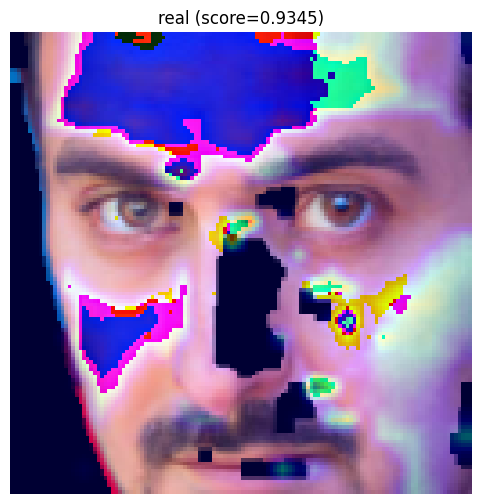

Prediction: real, Probability: 0.9345


In [86]:
from google.colab import files
import cv2
import numpy as np

# Upload image from browser
uploaded = files.upload()  # This will open a file picker

# Get the first uploaded file
for filename in uploaded.keys():
    img_path = filename
    break

# Now run your Grad-CAM function
last_conv = find_last_conv_layer(best_model)
prob, label = predict_and_gradcam(img_path, best_model, last_conv)

print(f"Prediction: {label}, Probability: {prob:.4f}")


In [87]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
train_gen = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/Dataset1/Train",
    target_size=(128,128),
    batch_size=32,
    class_mode='binary'
)

print(train_gen.class_indices)


Found 5016 images belonging to 2 classes.
{'Fake': 0, 'Real': 1}


Saving img12.jpg to img12.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


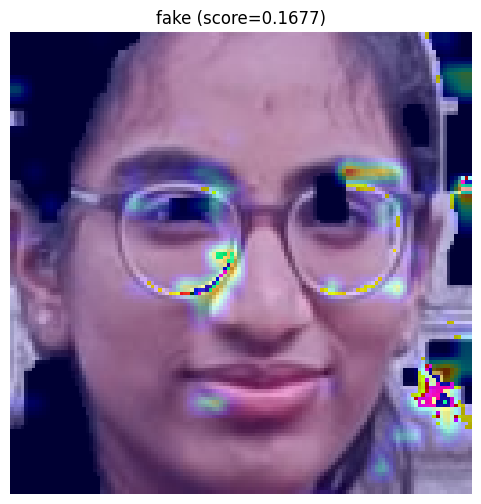

Prediction: fake, Probability: 0.1677


In [88]:
from google.colab import files
import cv2
import numpy as np

# Upload image from browser
uploaded = files.upload()  # This will open a file picker

# Get the first uploaded file
for filename in uploaded.keys():
    img_path = filename
    break

# Now run your Grad-CAM function
last_conv = find_last_conv_layer(best_model)
prob, label = predict_and_gradcam(img_path, best_model, last_conv)

print(f"Prediction: {label}, Probability: {prob:.4f}")


Saving Screenshot 2025-12-01 162845.png to Screenshot 2025-12-01 162845.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


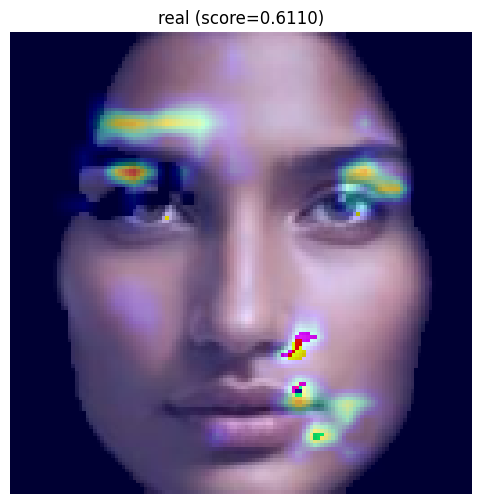

Prediction: real, Probability: 0.6110


In [89]:
from google.colab import files
import cv2
import numpy as np

# Upload image from browser
uploaded = files.upload()  # This will open a file picker

# Get the first uploaded file
for filename in uploaded.keys():
    img_path = filename
    break

# Now run your Grad-CAM function
last_conv = find_last_conv_layer(best_model)
prob, label = predict_and_gradcam(img_path, best_model, last_conv)

print(f"Prediction: {label}, Probability: {prob:.4f}")


Saving Screenshot 2025-12-01 162431.png to Screenshot 2025-12-01 162431.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


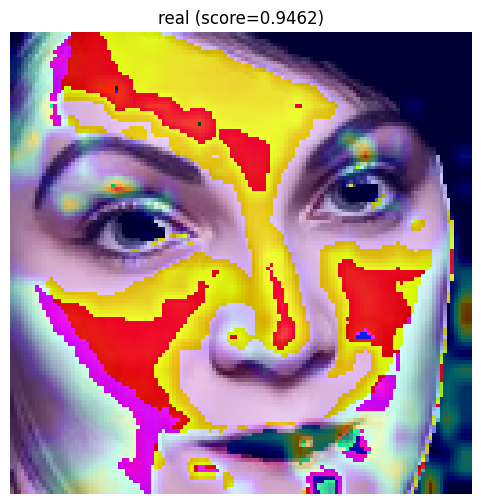

Prediction: real, Probability: 0.9462


In [90]:
from google.colab import files
import cv2
import numpy as np

# Upload image from browser
uploaded = files.upload()  # This will open a file picker

# Get the first uploaded file
for filename in uploaded.keys():
    img_path = filename
    break

# Now run your Grad-CAM function
last_conv = find_last_conv_layer(best_model)
prob, label = predict_and_gradcam(img_path, best_model, last_conv)

print(f"Prediction: {label}, Probability: {prob:.4f}")


Saving Screenshot 2025-12-01 162438.png to Screenshot 2025-12-01 162438.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


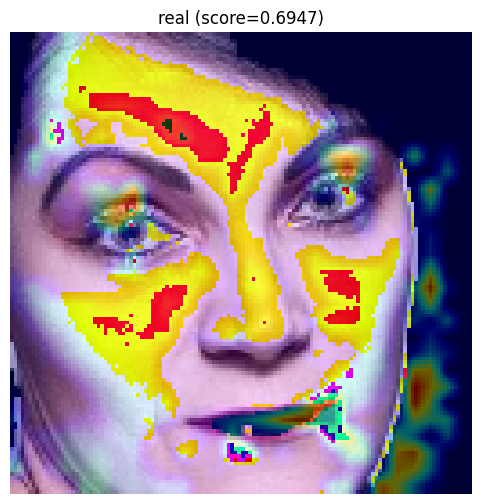

Prediction: real, Probability: 0.6947


In [91]:
from google.colab import files
import cv2
import numpy as np

# Upload image from browser
uploaded = files.upload()  # This will open a file picker

# Get the first uploaded file
for filename in uploaded.keys():
    img_path = filename
    break

# Now run your Grad-CAM function
last_conv = find_last_conv_layer(best_model)
prob, label = predict_and_gradcam(img_path, best_model, last_conv)

print(f"Prediction: {label}, Probability: {prob:.4f}")
